### To play around
You can just head to the section after results and load either the weighed_backup.csv or backup.csv to use the results from the cross validation, no need to run it through again.

### Changes from run-1

#### Test data
* Previously we used cross-validation to select the best model, and tested that model on data (opus 131) that we had kept apart from the beginning.
* The scores achieved when predicting on opus 131 were our final results.
* This time we train/validate on all data and take the final cross-validation scores as our results.

#### Crossvalidation
* Previously we simply took all sequences in the train/validate set, shuffled them and trained/validated with a 80/20 split.
* This time we instead shuffle the opuses (opi?) before generating the sequences, with the idea that this could hint at how patterns generalize across opuses with. So we basically have leave one (opus) out cross validation.

#### Input
* Previously we grouped similar chords together and grouped chords that appeared rarely (less than 10 times) under a single label.
* The idea was to remove outliers, reduce the output space and improve generalization
* As it was indicated that having the amount of output classes be dependent on the input was a bad idea we now use rules independent of the data for grouping and have ~800 classes instead of ~100

#### Model
* Previously we had a bi-directional LSTM layer in the model architecture as it increased performance. For the sake of being able to compare the results to a simple N-gram model we decided to remove that layer in this iteration.

#### Hyperparameters
* Given the increased amount of outliers and the removal of the bidirectional layer we expect generalization accuracy to decrease.
* To remedy that we used the current model and iterated through different values for a regularization parameter, which we didn't explore previously.
* Best scores were obtained with regstrength = 0 however.

#### Weighing
* Current version, multiply the metrics by the amount of chords in the opus being validated on. ?? Doublecheck


In [49]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
import seaborn as sns
sns.set()
sns.set_style("whitegrid")

from tensorflow.keras import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import *

from chord_functions import *

# Setup

In [50]:
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)

#Load all data
data = pd.read_csv('data/820chords.csv')

#Remove redundant attributes. Keep op to split into opuses
data = data[['chord', 'op']]

#Use dummy variable representation for the chords
data = pd.get_dummies(data)

# Model

In [3]:
def lstm(lstm_x, lstm_y, optimizer, loss, metrics, strength):
    model = Sequential()
    
    model.add(LSTM(256, return_sequences=True, input_shape=(lstm_x.shape[1], lstm_x.shape[2])))
    
    model.add(Dropout(strength))

    model.add(LSTM(64, return_sequences=False))
    
    model.add(Dropout(strength))
    
    model.add(Dense(lstm_y.shape[1], activation='softmax'))

    model.compile(loss=loss,
                  optimizer=optimizer,
                  metrics=metrics)
    return model

# Train/Test

### Select parameters for the learning process

In [4]:
optimizer = 'Adam'
loss = 'categorical_crossentropy'
metrics = ['accuracy']
epochs = 30
verbose = 2
seq_length = 10

#Save the weights whenever validation accuracy is increased
checkpoint = ModelCheckpoint(
    'weights.{epoch:02d}-{val_acc:.4f}.hdf5',
    monitor='val_acc', 
    verbose=0,        
    save_best_only=False
)
# Stop the learning process if we havent improved validation accuracy for 10 epochs
earlystop = EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=1)

#callbacks_list = [checkpoint, earlystop]   
callbacks_list = []  

### Cross validate

In [5]:
#define the range of regularization strengths to check
dropstrength = [0.3]
print("Start!")

#Create container for results
RESULTS = pd.DataFrame()

for strength in dropstrength:
    print("\nChecking dropout strength {}".format(strength))
    cv_results = pd.DataFrame()
    
    #Cross validate on each opus
    for opus in data['op'].unique():
        print("\nValidating on opus {}".format(opus))

        #Split into training and validation
        valid = data[data['op'] == opus]
        train = data[data['op'] != opus]

        #Drop the opus attribute since it's no longer needed
        valid = valid.drop(columns='op')
        train = train.drop(columns='op')

        #Generate sequences from the data
        valid_in, valid_out = generate_sequences(valid, valid, seq_length)
        train_in, train_out = generate_sequences(train, train, seq_length)

        #Create model
        model = lstm(train_in, train_out, optimizer, loss, metrics, strength)

        #Train on the folds
        model.fit(train_in,
                  train_out,
                  epochs = epochs,
                  verbose = verbose,
                  validation_data = (valid_in, valid_out),
                  callbacks = callbacks_list)

        #Save the history object for the model, appending test opus and regstrength
        history = pd.DataFrame(model.history.history)
        history.index.name = 'epoch'
        history['opus'] = opus
        history['reg'] = strength
        cv_results = cv_results.append(history)
    
    RESULTS = RESULTS.append(cv_results)

print("Done!")
pd.DataFrame.to_csv(RESULTS, './results/dropout_BACKUP.csv')

Start!

Checking dropout strength 0.3

Validating on opus 127
Train on 25863 samples, validate on 2210 samples
Epoch 1/30
 - 166s - loss: 4.0781 - acc: 0.1209 - val_loss: 4.1679 - val_acc: 0.1253
Epoch 2/30
 - 157s - loss: 3.9687 - acc: 0.1246 - val_loss: 4.1653 - val_acc: 0.1253
Epoch 3/30
 - 183s - loss: 3.9615 - acc: 0.1251 - val_loss: 4.1854 - val_acc: 0.1253
Epoch 4/30
 - 157s - loss: 3.9599 - acc: 0.1261 - val_loss: 4.1749 - val_acc: 0.1253
Epoch 5/30
 - 179s - loss: 3.9583 - acc: 0.1267 - val_loss: 4.1910 - val_acc: 0.1253
Epoch 6/30
 - 173s - loss: 3.9566 - acc: 0.1263 - val_loss: 4.1942 - val_acc: 0.1253
Epoch 7/30
 - 156s - loss: 3.9569 - acc: 0.1262 - val_loss: 4.2119 - val_acc: 0.1253
Epoch 8/30
 - 155s - loss: 3.9537 - acc: 0.1280 - val_loss: 4.1971 - val_acc: 0.1253
Epoch 9/30
 - 155s - loss: 3.9554 - acc: 0.1256 - val_loss: 4.2089 - val_acc: 0.1253
Epoch 10/30
 - 155s - loss: 3.9533 - acc: 0.1271 - val_loss: 4.1935 - val_acc: 0.1253
Epoch 11/30
 - 155s - loss: 3.9544 - a

Epoch 3/30
 - 155s - loss: 3.9270 - acc: 0.1269 - val_loss: 4.6513 - val_acc: 0.1139
Epoch 4/30
 - 155s - loss: 3.9212 - acc: 0.1263 - val_loss: 4.6996 - val_acc: 0.1139
Epoch 5/30
 - 155s - loss: 3.9195 - acc: 0.1272 - val_loss: 4.7033 - val_acc: 0.1139
Epoch 6/30
 - 155s - loss: 3.9192 - acc: 0.1275 - val_loss: 4.7295 - val_acc: 0.1139
Epoch 7/30
 - 155s - loss: 3.9184 - acc: 0.1268 - val_loss: 4.7416 - val_acc: 0.1139
Epoch 8/30
 - 155s - loss: 3.9314 - acc: 0.1287 - val_loss: 4.7375 - val_acc: 0.1139
Epoch 9/30
 - 155s - loss: 3.9097 - acc: 0.1284 - val_loss: 4.6849 - val_acc: 0.1139
Epoch 10/30
 - 155s - loss: 3.8817 - acc: 0.1335 - val_loss: 4.6797 - val_acc: 0.1143
Epoch 11/30
 - 155s - loss: 3.8679 - acc: 0.1365 - val_loss: 4.6386 - val_acc: 0.1250
Epoch 12/30
 - 155s - loss: 3.8499 - acc: 0.1398 - val_loss: 4.6077 - val_acc: 0.1328
Epoch 13/30
 - 155s - loss: 3.7994 - acc: 0.1499 - val_loss: 4.5607 - val_acc: 0.1415
Epoch 14/30
 - 155s - loss: 3.7663 - acc: 0.1565 - val_loss: 

 - 142s - loss: 3.7898 - acc: 0.1567 - val_loss: 3.8092 - val_acc: 0.1605
Epoch 7/30
 - 142s - loss: 3.7224 - acc: 0.1632 - val_loss: 3.7749 - val_acc: 0.1669
Epoch 8/30
 - 142s - loss: 3.6567 - acc: 0.1708 - val_loss: 3.7523 - val_acc: 0.1797
Epoch 9/30
 - 142s - loss: 3.5975 - acc: 0.1842 - val_loss: 3.7202 - val_acc: 0.1867
Epoch 10/30
 - 142s - loss: 3.5410 - acc: 0.1974 - val_loss: 3.7124 - val_acc: 0.1997
Epoch 11/30
 - 142s - loss: 3.4675 - acc: 0.2103 - val_loss: 3.7002 - val_acc: 0.1993
Epoch 12/30
 - 142s - loss: 3.4029 - acc: 0.2259 - val_loss: 3.7090 - val_acc: 0.2058
Epoch 13/30
 - 142s - loss: 3.3390 - acc: 0.2335 - val_loss: 3.7048 - val_acc: 0.2157
Epoch 14/30
 - 142s - loss: 3.2688 - acc: 0.2422 - val_loss: 3.7324 - val_acc: 0.2033
Epoch 15/30
 - 141s - loss: 3.1960 - acc: 0.2548 - val_loss: 3.7460 - val_acc: 0.2135
Epoch 16/30
 - 142s - loss: 3.1291 - acc: 0.2665 - val_loss: 3.7960 - val_acc: 0.2085
Epoch 17/30
 - 147s - loss: 3.0575 - acc: 0.2755 - val_loss: 3.7963 -

# Results

### Select which results to use

In [177]:
#Select to load the weighed or the unweighed results
RESULTS = pd.read_csv('results/lost_dropout.csv')
    
#Reindex
RESULTS = RESULTS.set_index(['dropout','opus'])

### For each regularization value, calculate the average cross-validated score and output it

In [178]:
AVERAGES = pd.DataFrame()

#For each level of regularization
for regularization, cvscores in RESULTS.groupby(level=0):
    average = pd.DataFrame()
    
    #Iterate through all folds and extract the highest validation scores
    for opus, fold in cvscores.groupby(level=1):

        #Retrieve the best score
        best = fold[fold['val_acc'] == fold['val_acc'].max()]
        average = average.append(best)
    
    #Make a pretty dataframe of the mean
    average = average.describe().loc[['mean']]
    average = average.rename(index={'mean': regularization})
    
    #Take the mean scores for this regularization value and store them in AVERAGE for comparisons
    AVERAGES = AVERAGES.append(average)

BEST = AVERAGES[AVERAGES['val_acc'] == AVERAGES['val_acc'].max()]

print("Full table of cross validated scores for each regularization value")
display(AVERAGES)

print("Best score")
display(BEST)

Full table of cross validated scores for each regularization value


,epoch,val_loss,val_acc,loss,acc
0.0,16.256410,4.157349,0.142454,3.781082,0.156236
0.1,15.950000,4.492862,0.134817,3.781125,0.152620
0.2,21.555556,3.930322,0.195356,3.419244,0.221256
0.3,17.666667,3.957590,0.195784,3.369093,0.227901


Best score


,epoch,val_loss,val_acc,loss,acc
0.3,17.666667,3.95759,0.195784,3.369093,0.227901


# Graphs

### For each dropout value, plot the valacc as a function of epoch

Text(0.5, 0, 'Epoch')

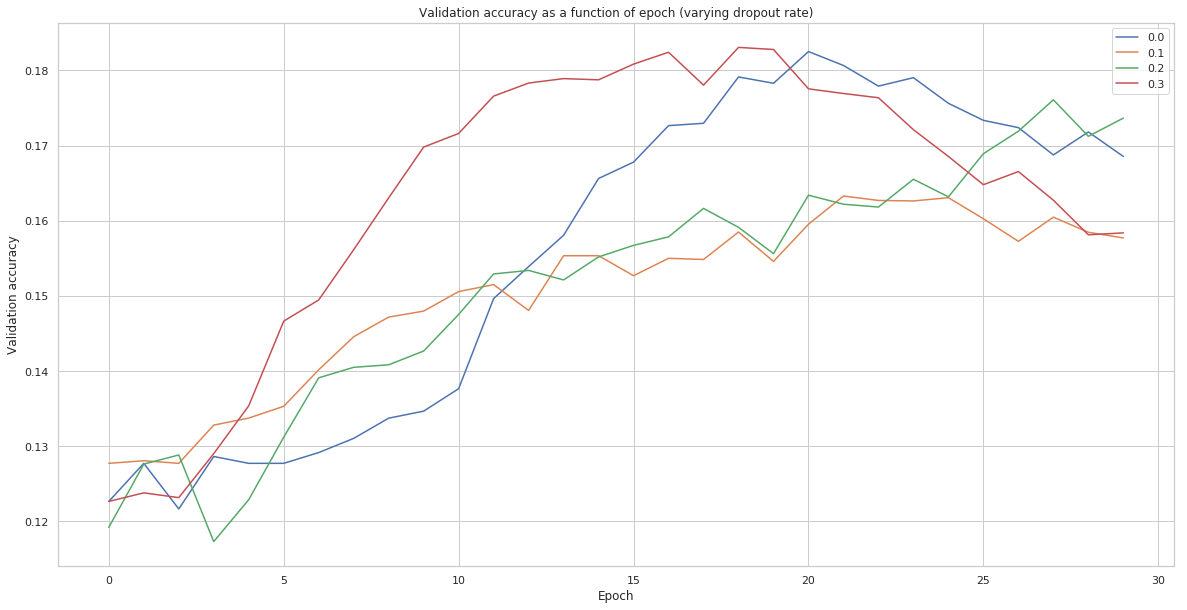

In [261]:
val_curves = []

#For each level of parameter
for parameter, cvscores in RESULTS.groupby(level=0):
    average = pd.DataFrame()
    for epoch in range(epochs):
        mean = (cvscores[cvscores.epoch == epoch]).describe().loc[['mean']]
        average = average.append(mean)
    average = average.set_index(['epoch'])
    average['param'] = parameter
    val_curves.append(average)
    
fig, ax = plt.subplots(figsize=(20,10))
for c in val_curves:
    sns.lineplot(data=c['val_acc'],label=c.iloc[0].param)
ax.set_title("Validation accuracy as a function of epoch (varying dropout rate)")
ax.set_ylabel("Validation accuracy")
ax.set_xlabel("Epoch")


### Chords in each opus

In [ ]:
sizes = data.groupby('op')[['chord_#I']].count()
sizes = sizes.rename(columns={'chord_#I': 'count'})
#sizes = sizes.sort_values(by = 'count', ascending=False)
sizes = sizes.append(sizes.describe().loc[['mean']])

fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=sizes.T)
ax.set_title("Amount of chords in each opus")
ax.set_ylabel("Chords")
ax.set_xlabel("Opus")
plt.show()

fig.savefig("./figs/chords_per_opus.png")

### Validation accuracy for each opus

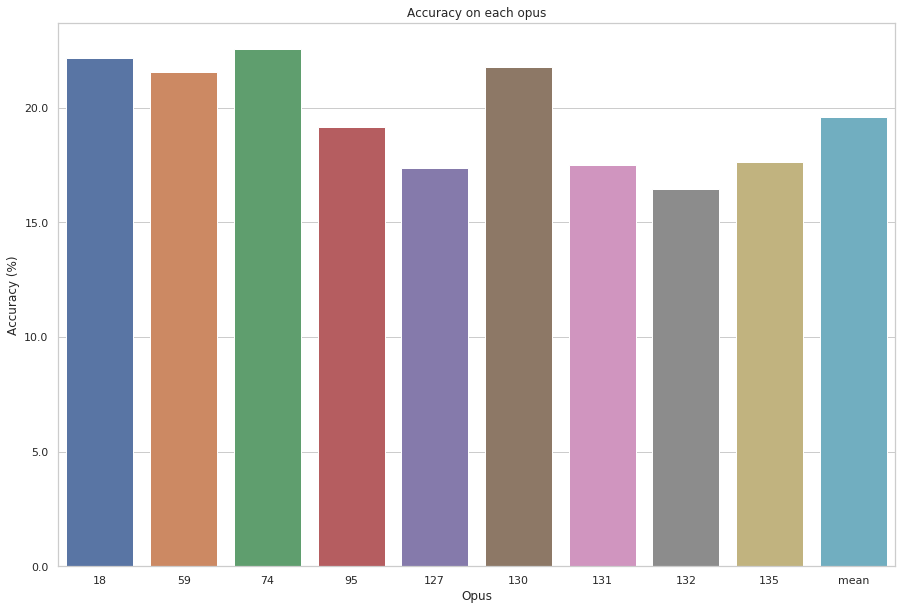

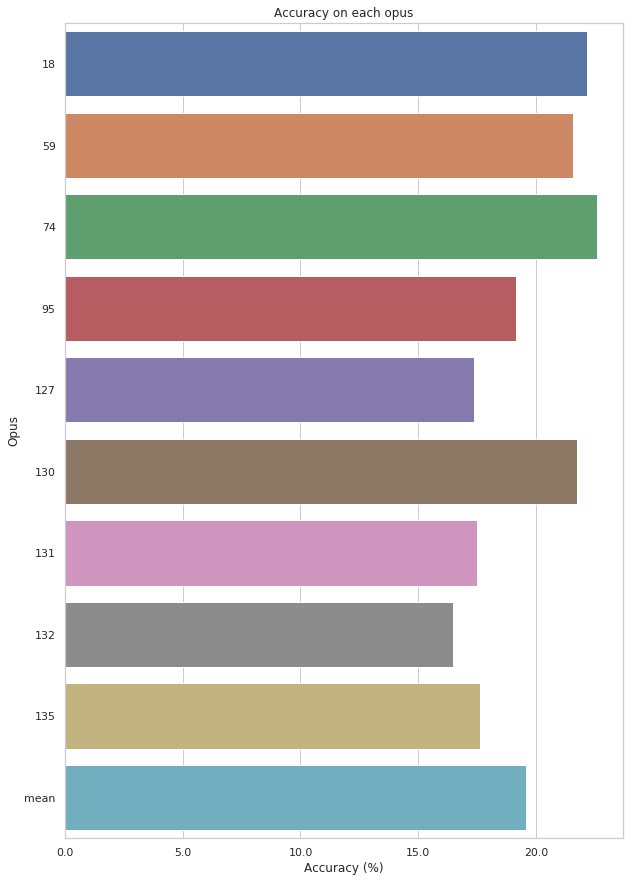

In [179]:
#Use the data from the reg_value that produced the best results
best_reg = BEST.index.values[0]
df = RESULTS.loc[best_reg]

#For each of the nine folds/opuses...
scores = pd.DataFrame()
for opus, fold in df.groupby(level=0):
        
        #Drop potential duplicate values
        fold = fold.drop_duplicates(subset='val_acc')
        
        #Retrieve the scores when the val_acc was highest
        score = fold[fold['val_acc'] == fold['val_acc'].max()]
        
        #Store
        scores = scores.append(score)

#Sort scores by valacc
#scores = scores.sort_values(by='val_acc', ascending=False)

#Append the average score to the individual scores
avg = BEST.rename(index={best_reg: 'mean'})
    
scores = scores.append(avg)

#Plot them
fig, ax = plt.subplots(figsize=(15,10))
sns.barplot(data=scores[['val_acc']].T)
ax.set_title("Accuracy on each opus")
ax.set_ylabel("Accuracy (%)")
ax.set_xlabel("Opus")
ax.set_yticklabels(np.around(ax.get_yticks()* 100,2))
#fig.savefig("./figs/Weighed_NNacc_V.png")
fig.savefig("./figs/NNacc_V.png")

fig, ax = plt.subplots(figsize=(10,15))
sns.barplot(data=scores[['val_acc']].T, orient='horizontal')
#ax.set_title("Weighed accuracy on each opus")
ax.set_title("Accuracy on each opus")
ax.set_xlabel("Accuracy (%)")
ax.set_ylabel("Opus")
ax.set_xticklabels(np.around(ax.get_xticks()* 100,2))
#fig.savefig("./figs/Weighed_NNacc_H.png")
fig.savefig("./figs/NNacc_H.png")

plt.show()